# MO651 - Robótica Móvel - Trabalho 01
### Equipe: 
* Daiane Mendes - RA: 230210
* Carlos Victor - RA: 230261
* João Paulo - RA: 230221
* Pedro Olímpio - RA: 230256


## Introdução


In [1]:
import sys, time, random, math, cv2
import numpy as np
from matplotlib import pyplot as plt
import skfuzzy as fuzz
from skfuzzy import control as ctrl

sys.path.insert(0, '../src')
from robot import Robot

In [2]:
def pre_process_image(resolution, image):
    img = np.array(image,dtype=np.uint8)
    img.resize([resolution[1],resolution[0],3])
    
    cv2.imwrite('vision'+'.png',cv2.flip(img, 0))
    
    return cv2.flip(img, 0)

def apply_mask_by_color(image):
    hsv = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)
    # define range of blue color in HSV
    lower_blue = np.array([110,50,50])
    upper_blue = np.array([130,255,255])
    
    # Threshold the HSV image to get only blue colors
    mask = cv2.inRange(hsv, lower_blue, upper_blue)
    
    # Bitwise-AND mask and original image
    return cv2.bitwise_and(image,image, mask= mask)

def calculate_center(image):
    cv2.imwrite('masked'+'.png',image)
    # convert image to grayscale image
    gray_image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY) 
    # convert the grayscale image to binary image
    ret,thresh = cv2.threshold(gray_image,10,255, cv2.THRESH_BINARY)
    
    cv2.imwrite('thresh'+'.png',thresh)
    
    img, contours, hierarchy = cv2.findContours(thresh,cv2.RETR_TREE,cv2.CHAIN_APPROX_SIMPLE)
    maximo = 0
    cmax = None
    for c in contours:
        area = cv2.contourArea(c)
        if area > maximo:
            maximo = area
            cmax = c
        
    # calculate moments for each contour
    M = cv2.moments(cmax)
    if(M["m00"] != 0 ):
        # calculate x,y coordinate of center
        cX = int(M["m10"] / M["m00"])
        cY = int(M["m01"] / M["m00"])

        cv2.circle(image, (cX, cY), 5, (255, 255, 255), -1)
        cv2.putText(image, "center", (cX - 25, cY - 25),cv2.FONT_HERSHEY_SIMPLEX, 0.5, (255, 255, 255), 2)

        # display the image
        cv2.imwrite('door'+'.png',image)
        return cX, cY, True
    
    return 0, 0, False

In [3]:
def laser_sensors(laser, c_position, gamma, label):
    x = []
    y = []
    
    rotation_matrix = np.matrix([[math.cos(gamma), -math.sin(gamma)], [math.sin(gamma), math.cos(gamma)]])
    for i in range(0, len(laser), 3):
        robot_position = np.matrix([[c_position[0]], [c_position[1]]])
        translation_matrix =  np.matrix([[laser[i]], [laser[i+1]]])
        T = np.matmul(rotation_matrix, translation_matrix)
        final_result = np.add(T, robot_position)
        x.append(final_result.item((0, 0)))
        y.append(final_result.item((1, 0)))
    plt.plot(x, y, label)

def update_map_gt():
    c_position = robot.get_current_position()
    c_orientation = robot.get_current_orientation()[2]
    laser = robot.read_laser()
    plt.figure(1)
    print(c_orientation)
    laser_sensors(laser, c_position, c_orientation, 'b.')
    plt.savefig('map_gt'+'.png')

def update_map_odometry(o_position, orientation):
    laser = robot.read_laser()
    plt.figure(2)
    print(orientation)
    laser_sensors(laser, o_position, orientation, 'r.')
    plt.savefig('map_odometry'+'.png')

def update_map(o_position, orientation):
    update_map_gt()
    update_map_odometry(o_position, orientation)

In [4]:
def front_sensors_move(dist, vel):
    vLeft = vRight = defaultVelocity
    if (dist[3] < noDetectionDist or dist[4] < noDetectionDist):
        side = random.randint(0,1)
        if (dist[2] < noDetectionDistDiag and dist[5] > noDetectionDistDiag):
            side = 0
        elif (dist[5] < noDetectionDistDiag and dist[2] > noDetectionDistDiag):
            side = 1
        elif (dist[2] < noDetectionDistDiag and dist[5] < noDetectionDistDiag):
            distance = robot.read_ultrassonic_sensors()
            if (distance[2] < noDetectionDistDiag or distance[5] < noDetectionDistDiag or distance[1] < noDetectionDistDiag or distance[6] < noDetectionDistDiag):
                return[-defaultVelocity, -defaultVelocity]
        if (side != 0):
            distance = robot.read_ultrassonic_sensors()
            if (distance[3] < noDetectionDist or distance[4] < noDetectionDist):
                return [-(defaultVelocity)/2, defaultVelocity/2]
        else:
            distance = robot.read_ultrassonic_sensors()
            if (distance[3] < noDetectionDist or distance[4] < noDetectionDist):
                return [defaultVelocity/2, -defaultVelocity/2]
    return [vLeft, vRight]

def walk(left_velocity, right_velocity, time_to_walk):
    robot.set_left_velocity(left_velocity)
    robot.set_right_velocity(right_velocity)  
    time.sleep(time_to_walk)


def enter_door(position, orientation):
    resolution, image = robot.read_vision_sensor()
    aux = resolution[0]/2
    image = pre_process_image(resolution, image)
    door = apply_mask_by_color(image)
    X,Y,isCenter = calculate_center(door)
    X += 5
    
    if (isCenter):
        while isCenter and abs(X - aux) > 5:
            if(X < aux):
                robot.set_left_velocity(-0.05)
                robot.set_right_velocity(0.05)

            elif(X >= aux):
                robot.set_left_velocity(0.05)
                robot.set_right_velocity(-0.05)
                
            _, image = robot.read_vision_sensor()
            image = pre_process_image(resolution, image)
            door = apply_mask_by_color(image)
            X,Y,isCenter = calculate_center(door)
            X += 5
        if not isCenter:
            return
    
        us_distances = robot.read_ultrassonic_sensors()
        dist_front = min(us_distances[3], us_distances[4])
        while (dist_front > 0.3):
            robot.set_left_velocity(min(defaultVelocity, dist_front))
            robot.set_right_velocity(min(defaultVelocity, dist_front))
            us_distances = robot.read_ultrassonic_sensors()
            dist_front = min(us_distances[3], us_distances[4])
            
        while (dist_front < 7):
            robot.set_left_velocity(0.3)
            robot.set_right_velocity(-0.3)
            us_distances = robot.read_ultrassonic_sensors()
            dist_front = min(us_distances[3], us_distances[4])
        time.sleep(0.5)
        
        walk(defaultVelocity, defaultVelocity, 15)
        update_map(position, orientation)
        
        walk(1, -1, 4)
        update_map(position, orientation)

        walk(-1, 1, 8)
        update_map(position, orientation)
        
        walk(1, -1, 4)
        
        walk(-defaultVelocity, -defaultVelocity, 20)
        walk(2, -2, 2)


In [5]:
def calculate_delta(begin, end, spinOrient):
    if math.isclose(float(end), float(begin), abs_tol=0.00001):
        return 0
    end = (limit + end) % limit
    begin = (limit + begin) % limit

    ans = abs(end - begin)
    if spinOrient:
        if begin < end:
            return limit - ans
        return ans
    if begin > end:
        return limit - ans
    return ans

def calculate_speed(time, clockwiseSpin, lastEncoder, motorHandle):
    encoder = robot.get_joint_position(motorHandle)
    delta = calculate_delta(lastEncoder, encoder, clockwiseSpin)
    
    lastEncoder = encoder
    if delta > math.pi:
        delta = (2 * math.pi) - delta
        clockwiseSpin = not clockwiseSpin
    
    speed = 0.0975 * (delta/time)
    if(clockwiseSpin):
        return -speed, clockwiseSpin, lastEncoder
    
    return speed, clockwiseSpin, lastEncoder

def to180Universe(alpha):
    alpha = alpha % (2 * math.pi)
    if alpha > math.pi:
        return alpha - (2 * math.pi)
    return alpha

def to360Universe(alpha):
    if alpha < 0:
        return (2 * math.pi) + alpha
    return alpha

def add_angle(alpha, beta):
    angle = to360Universe(alpha) + to360Universe(beta)
    return to180Universe(angle)

def new_position(alpha, x, y):
    global lastTime
    global lastEncoderL, lastEncoderR
    global clockwiseSpinL, clockwiseSpinR
    
    now = time.time()
    dtime = now-lastTime
    lastTime = now
    
    vL, clockwiseSpinL, lastEncoderL = calculate_speed(dtime, clockwiseSpinL, lastEncoderL, 'left')
    vR, clockwiseSpinR, lastEncoderR = calculate_speed(dtime, clockwiseSpinR, lastEncoderR, 'right')
    
    w = (vR-vL)/0.36205
    v = (vR + vL)/2.0
    
    dAlpha = w*dtime
    dL = vL*dtime
    dR = vR*dtime
    dM = (dL+dR)/2.0
    dX = dM*math.cos(add_angle(alpha, dAlpha/2.0))
    dY = dM*math.sin(add_angle(alpha, dAlpha/2.0))
    return x+dX, y+dY, add_angle(alpha, dAlpha)

def plot_odometry_vs_GT(path, path_odometry):
    _, ax = plt.subplots(figsize=(9, 9))
    ax.plot(path_odometry[:,0], path_odometry[:,1], label = 'Odometry')
    ax.plot(path[:,0], path[:,1], label = 'Ground Truth')
    ax.grid(True)
    ax.legend(loc='best')
    plt.xlabel("x")
    plt.ylabel("y")
    plt.title('Odometry x Ground Truth')
    plt.savefig('odometry'+'.png') 
#     plt.show()

In [6]:
class GoToGoalPID():
    epsilonA = 25
    KpA = 1.5
    KiA = KpA / 10.0
    KdA = KpA * 5
    epsilonP = 0.01
    KpP = 0.7
    KdP = KpP * 5
    
    def __init__(self):
        self.errorA = self.epsilonA
        self.oldErrorA = 0
        self.accErrorA = 0
        self.errorP = self.epsilonP
        self.oldErrorP = 0
    
    def calcule_norm_angle(self, angle):
        return angle % (2*math.pi)

    def calcule_x1_y1_angle(self, position, angle, goal):
        x1 = position[0] - goal[0]
        y1 = position[1] - goal[1]
        angle = self.calcule_norm_angle(angle)
        return x1, y1, angle

    def calcule_errorA(self, position, angle, goal):
        x1, y1, angle = self.calcule_x1_y1_angle(position, angle, goal)
        goalAngle = self.calcule_norm_angle(math.pi + math.atan2(y1, x1))
        self.errorA = math.atan2(math.sin(goalAngle-angle), math.cos(goalAngle-angle))

    def calcule_go_to_position(self, position, angle, goal):
        x1, y1, angle = self.calcule_x1_y1_angle(position, angle, goal)
        goalAngle = self.calcule_norm_angle(math.pi + math.atan2(y1, x1))
        deltaA = math.degrees(math.atan2(math.sin(goalAngle-angle), math.cos(goalAngle-angle)))
        sig = -1 if abs(deltaA) > 100 else 1

        self.errorP = sig * math.sqrt( ((goal[0]-position[0])**2) + ((goal[1]-position[1])**2) )
        diffErrorP = self.errorP - self.oldErrorP
        u = (self.KpP * self.errorP) + (self.KdP * diffErrorP)
        self.oldErrorP = self.errorP
        return [u,u]


    def calcule_go_to_angle(self, position, angle, goal):
        self.calcule_errorA(position, angle, goal)
        self.accErrorA = self.accErrorA + self.errorA
        diffErrorA = self.errorA - self.oldErrorA
        u = (self.KpA * self.errorA) + (self.KiA * self.accErrorA) + (self.KdA * diffErrorA)
        self.oldErrorA = self.errorA
        return [u,-u]


    def go_to_goal_PID(self, position, angle, goal):
        if abs(math.degrees(self.errorA)) < self.epsilonA:
            self.calcule_errorA(position, angle, goal)
            if abs(self.errorP) >= self.epsilonP:
                return self.calcule_go_to_position(position, angle, goal)
            else:
                return [0,0]
        else:
            return self.calcule_go_to_angle(position, angle, goal)



In [7]:
ls = ctrl.Antecedent(np.arange(0,10.1,0.1), 'left sensor')
fs = ctrl.Antecedent(np.arange(0,10.1,0.1), 'front sensors')
rs = ctrl.Antecedent(np.arange(0,10.1,0.1), 'right sensor')

ls['near'] = fuzz.trimf(ls.universe, [0, 0, 3])
ls['far'] = fuzz.trapmf(ls.universe, [0, 3, 10, 10])

fs['near'] = fuzz.trimf(fs.universe, [0, 0, 3])
fs['far'] = fuzz.trapmf(ls.universe, [0, 3, 10, 10])

rs['near'] = fuzz.trimf(rs.universe, [0, 0, 3])
rs['far'] = fuzz.trapmf(ls.universe, [0, 3, 10, 10])

f_vel = ctrl.Consequent(np.arange(0, 11, 1), 'velocity')
f_angle = ctrl.Consequent(np.arange(-2,2,0.1), 'angle')

f_vel['no movement'] = fuzz.trimf(f_vel.universe, [0, 0, 3])
f_vel['slow'] = fuzz.trimf(f_vel.universe, [0, 3, 6])
f_vel['fast'] = fuzz.trapmf(f_vel.universe, [3, 6, 10, 10])

f_angle['left'] = fuzz.trimf(f_angle.universe, [-2, -2, 0])
f_angle['forward'] = fuzz.trimf(f_angle.universe, [-0.2, 0, 0.2])
f_angle['right'] = fuzz.trimf(f_angle.universe, [0, 2, 2])

rules = []
rules.append(ctrl.Rule(ls['near'] & fs['near'] & rs['near'], [f_vel['no movement'], f_angle['left']]))
rules.append(ctrl.Rule(ls['far'] & fs['near'] & rs['far'], [f_vel['slow'], f_angle['forward']]))
rules.append(ctrl.Rule(ls['near'] & fs['far'] & rs['near'], [f_vel['slow'], f_angle['forward']]))
rules.append(ctrl.Rule(ls['far'] & fs['far'] & rs['far'], [f_vel['fast'], f_angle['forward']]))

rules.append(ctrl.Rule(ls['near'] & fs['near'] & rs['far'], [f_vel['slow'], f_angle['left']]))
rules.append(ctrl.Rule(ls['far'] & fs['near'] & rs['near'], [f_vel['slow'], f_angle['right']]))

rules.append(ctrl.Rule(ls['near'] & fs['far'] & rs['far'], [f_vel['fast'], f_angle['forward']]))
rules.append(ctrl.Rule(ls['far'] & fs['far'] & rs['near'], [f_vel['fast'], f_angle['forward']]))

def avoid_obstacles(sensors):
    avoid_ctrl = ctrl.ControlSystem(rules)
    avoid = ctrl.ControlSystemSimulation(avoid_ctrl)
    
    avoid.input['left sensor'] = sensors[2]
    avoid.input['front sensors'] = min(sensors[3], sensors[4])
    avoid.input['right sensor'] = sensors[5]
    
    avoid.compute()
    
    vel = avoid.output['velocity']
    angle = avoid.output['angle']
    
#    return [(1 + min(0, angle)) * vel, (1 - max(0, angle)) * vel]
    return [(1 - max(0, angle)) * vel, (1 + min(0, angle)) * vel]
    

In [14]:
noDetectionDist = 0.7
defaultVelocity = 1
noDetectionDistDiag = 0.4

robot = Robot()

limit = 2*math.pi
lastTime=time.time()
clockwiseSpinL = False
clockwiseSpinR = False
lastEncoderL = robot.get_joint_position('left')
lastEncoderR = robot.get_joint_position('right')

position = robot.get_current_position()
orientation = robot.get_current_orientation()

alpha = orientation[2]
x = position[0]
y = position[1]


goal = np.array([3.32, -1.8])
goToGoalPID = GoToGoalPID()

path = []
path_odometry = []

while(robot.get_connection_status() != -1):
    us_distances = robot.read_ultrassonic_sensors()
    (left_vel, right_vel) = avoid_obstacles(us_distances)
    
    robot.set_left_velocity(left_vel)
    robot.set_right_velocity(right_vel)
    
#     angle = robot.get_current_orientation()[2]
#     position = robot.get_current_position()    
    
#     vGoToPID = goToGoalPID.go_to_goal_PID(position, angle, goal)
    
#     robot.set_left_velocity(vGoToPID[1])
#     robot.set_right_velocity(vGoToPID[0])
#     print(vGoToPID)
    
#     us_distances = robot.read_ultrassonic_sensors()
#     vel = front_sensors_move(us_distances[:8], defaultVelocity)
#     walk(vel[0], vel[1], 3)
#     walk(0, 0, 0)
    
#     update_map([x,y,0], alpha)
        
#     enter_door([x,y,0], alpha)
    
    # Odometria
    x, y, alpha = new_position(alpha, x, y)
    path.append([-position[1], position[0]])
    path_odometry.append([-y, x])
    

Connected to remoteApi server.
 Pioneer_p3dx_ultrasonicSensor1 connected.
 Pioneer_p3dx_ultrasonicSensor2 connected.
 Pioneer_p3dx_ultrasonicSensor3 connected.
 Pioneer_p3dx_ultrasonicSensor4 connected.
 Pioneer_p3dx_ultrasonicSensor5 connected.
 Pioneer_p3dx_ultrasonicSensor6 connected.
 Pioneer_p3dx_ultrasonicSensor7 connected.
 Pioneer_p3dx_ultrasonicSensor8 connected.
 Pioneer_p3dx_ultrasonicSensor9 connected.
 Pioneer_p3dx_ultrasonicSensor10 connected.
 Pioneer_p3dx_ultrasonicSensor11 connected.
 Pioneer_p3dx_ultrasonicSensor12 connected.
 Pioneer_p3dx_ultrasonicSensor13 connected.
 Pioneer_p3dx_ultrasonicSensor14 connected.
 Pioneer_p3dx_ultrasonicSensor15 connected.
 Pioneer_p3dx_ultrasonicSensor16 connected.
 Vision sensor connected.
 Laser connected.
 Left motor connected.
 Right motor connected.
 Robot connected.


KeyboardInterrupt: 

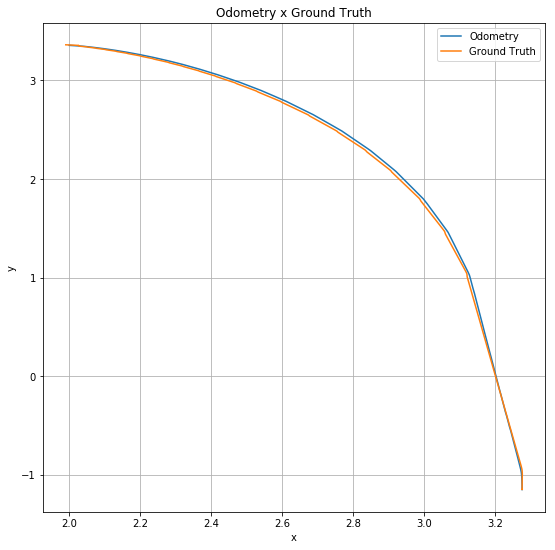

In [ ]:
if(len(path) > 0):
    path = np.array(path)
    path_odometry = np.array(path_odometry)

    difx = path[1,0] - path_odometry[1,0]
    dify = path[1,1] - path_odometry[1,1]
    path_odometry[:,0] = path_odometry[:,0]+difx
    path_odometry[:,1] = path_odometry[:,1]+dify

    plot_odometry_vs_GT(path, path_odometry)